## CNN : Skin lesion image classification

Groupe :

    *   AIT-AHMAD Kaoutar
    *   HADROUCH Chaimae 
    *   LO Aïssatou Mbene

The objective of this first method is to build a convolutional neural network (CNN) using PyToch framework.

To make the optimization efficient, will work with the GPU acceleration provided by Colab. To set the GPU acceleration:



*   Edit
*   Notebook settings
*   Hardware accelerator: GPU

**Data:**
We will use the *Skin lesion *dataset for image classification. It is composed of 25331 images .







# Sample code to read data

In [ ]:
# a command to manage and monitor NVIDIA GPU device.
!nvidia-smi

Sun Mar  6 13:53:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    68W / 149W |   3450MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Read data

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import time
import copy

from PIL import Image
import matplotlib.pyplot as plt

from tqdm import tqdm

# Short names of categories/ 8 classes for classifications 
classes = ["MEL", "NV", "BCC", "AK", "BKL", "DF", "VASC", "SCC"]

# Path to image data
#img_path="../input/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input"
img_path='gdrive/My Drive/Projet_ML/'

# Load data frame containing category annotations
df_all = pd.read_csv(os.path.join(img_path,"gt_train_test.csv"))

# data frame for training (with categories)
df_annot = df_all[df_all['target']>=0]

# data frame for testing (without categories)
df_test = df_all[df_all['target']<0]

# load or image data
#img_data_tensor = np.load('../input/iogs-atsi-skin-classification-2022/isic2019_img_data.npz')
if (os.path.exists(os.path.join(img_path,'isic2019_img_data_224.npz'))):
  img_data_tensor = np.load(os.path.join(img_path,'isic2019_img_data_224.npz'))
  img_all = img_data_tensor['img_data']
else:
  img_all = []

  # To create square image
  def center_crop(pil_img):
      img_width, img_height = pil_img.size
      if img_width > img_height:
          crop_size = img_height
      else:
          crop_size = img_width
      return pil_img.crop(((img_width - crop_size) // 2,
                          (img_height - crop_size) // 2,
                          (img_width + crop_size) // 2,
                          (img_height + crop_size) // 2))
      
  for im in tqdm(df_all['image']):
      x = Image.open(os.path.join(img_path, "{}.jpg".format(im)))
      x = center_crop(x)
      img_all.append(np.array(x.resize((224,224))))

  np.savez_compressed(os.path.join(img_path,'isic2019_img_data_224.npz'), img_data=np.array(img_all))

y_all = df_all['target']

print(img_all.shape)

## Create dataset

In [ ]:
# Create train, val and test splits
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(img_all[df_all['target']>=0,:,:,:], y_all[df_all['target']>=0], test_size=0.2, random_state=123)

x_test = img_all[df_all['target']<0,:,:,:]
y_test = y_all[df_all['target']<0]


NameError: ignored

In [ ]:
# Pytorch
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.optim import lr_scheduler
import torch.nn.functional as F
import torch.nn as nn

# Create dataset
class MyDatasetRaw(Dataset):
    """ISIC 2019 dataset."""
    # classes = {'NV': 0, 'MEL': 1, 'BKL': 2, 'DF': 3, 'SCC': 4, 'BCC': 5, 'VASC': 6, 'AK': 7}
    
    def __init__(self, raw_data, targets, transform=None):
        """
        Args:
        """
        self.raw_data = raw_data
        self.targets = targets
        self.transform = transform        
    
    def __getitem__(self, idx):
        x = Image.fromarray(self.raw_data[idx, :, :, :])
        #x = read_image(os.path.join(self.img_path, "{}.jpg".format(image_id)))
        x = self.center_crop(x)
        if self.transform:
            x = self.transform(x)
        y = self.targets.iloc[idx]
        y = np.int64(y)
        id=self.targets.index[idx]
        return {"image": x, "label": y, "Id": id}
            
    def __len__(self):
        return int(len(self.raw_data))
    
    # To create square image
    def center_crop(self, pil_img):
        img_width, img_height = pil_img.size
        if img_width > img_height:
            crop_size = img_height
        else:
            crop_size = img_width
        return pil_img.crop(((img_width - crop_size) // 2,
                             (img_height - crop_size) // 2,
                             (img_width + crop_size) // 2,
                             (img_height + crop_size) // 2))


The Dataset class, allow to apply data transformation such as normalization or data augmentation.

## Create data loaders
To be used in pytorch

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 25

input_size = 224

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                         transforms.RandomVerticalFlip(),
                                         transforms.ColorJitter(brightness=32. / 255., saturation=0.5),
                                         transforms.Resize(input_size),
                                         transforms.ToTensor(),
                                     normalize])

val_transform = transforms.Compose([transforms.Resize(input_size),
                                    transforms.ToTensor(),
                                   normalize])
        
kwargs = {'num_workers': 2, 'pin_memory': True} if torch.cuda.is_available() else {}

train_set_raw = MyDatasetRaw(x_train, y_train, transform = train_transform)
train_dataloader = DataLoader(train_set_raw, batch_size=batch_size, shuffle=True, **kwargs)

val_set_raw = MyDatasetRaw(x_val, y_val, transform = val_transform)
val_dataloader = DataLoader(val_set_raw, batch_size=batch_size, shuffle=False, **kwargs)

## Test data loader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


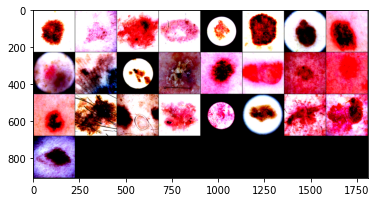

In [ ]:
it = iter(val_dataloader)
sample = it.next()

out = torchvision.utils.make_grid(sample['image'])
plt.imshow(out.permute(1, 2, 0))


## Create network

We create a network with 2 convolutions and 3 linear layers.

In the __init__ function, you need to declare the layers with parameters (convolutional and linear layers). In the forward function, you describe the information flow from the input (x) to the final output.

**The object with parameters are:**
nn.Conv2d(a,b,c) where a is the input channel number, b the output channel number and c the kernel size.
nn.Linear(a,b) where a is the input size, b the output size

**Here are some useful functions:**
F.relu(a): apply a relu on a
F.max_pool2d(a,2): apply a max pooling of size 2 on a
b = a.view(a.size(0), -1): flattens a to be usable with linear layer 

**The network will be:**

conv (3 -> 16, kernel 5x5)

relu 

max_pooling

conv (16 -> 32, kernel 5x5)

relu 

max_pooling


Linear (89888 (32x53x53) -> 1200)

relu

Linear (1200 -> 840)

relu

Linear (840 -> 8 (8classes))



In [ ]:
# network class
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.optim import lr_scheduler
from tqdm import tqdm # for progress bars
from sklearn.metrics import confusion_matrix
from IPython.display import clear_output


class SimpleCNN(nn.Module):
  
  def __init__(self):
    super(SimpleCNN, self).__init__()

    # define here the convolutions and linear layers
    self.conv1 = nn.Conv2d(3, 16, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(16, 32, 5)
    self.fc1 = nn.Linear(32*53*53, 1200)
    self.fc2 = nn.Linear(1200, 840)
    self.fc3 = nn.Linear(840, 8)
    
  def forward(self, x):
        
    # define here the forward pass
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 32*53*53)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return x

## Learning function



## Training and Test

In [ ]:
def accuracy(cm):
    
    return cm.trace() / cm.sum()

**The algorithm that we followed for training:**



*   We set the gradients to zero.

*   We compute the outputs.

*   We compute the cross entropy loss.

*   We call backward on the loss.

*   We call step on the optimizer.

*   We compute the predictions on the outputs (in numpy format), it is the argmax of the prediction vector.

*   We update the confusion matrix.

**The algorithm that we followed for test:**

*   We compute the outputs.

*   We compute the predictions on the outputs (in numpy format), it is the argmax of the prediction vector.

*   We update the confusion matrix.









In [ ]:
# create the network
network = SimpleCNN()
network.cuda()

max_epoch = 25 
learning_rate = 0.001

# We use CrossEntropy as criterion
criterion = nn.CrossEntropyLoss()  


# create an optimizer , We use Adam as optimizer
optimizer = torch.optim.Adam(network.parameters(), lr=1e-5)


# list for saving accuracies
train_accs = []
val_accs = []

train_dataloader = DataLoader(train_set_raw, batch_size=batch_size, shuffle=True, **kwargs)

val_dataloader = DataLoader(val_set_raw, batch_size=batch_size, shuffle=False, **kwargs)

# iterate over epochs
for epoch in range(max_epoch):
    
    # set the network in train mode
    network.train()
    
    # create a zero confuction matrix
    cm = np.zeros((10,10))
    
    for sample in tqdm(train_dataloader, ncols=80, desc="Epoch {}".format(epoch)):

        inputs = sample['image']
        targets = sample['label']
        inputs = inputs.cuda()
        targets = targets.cuda()

        # gradients to zero
        optimizer.zero_grad()
        
        # compute outputs
        outputs = network(inputs)
        
        # compute loss
        loss = F.cross_entropy(outputs, targets)
        
        # backward on loss
        loss.backward()
        
        # optimizer step
        optimizer.step()

        # convert the torch tensors to numpy
        outputs_np = outputs.cpu().detach().numpy()
        targets_np = targets.cpu().detach().numpy()
        
        # compute the predictions
        pred = np.argmax(outputs_np, axis=1)
        
        # update the confusion matrix
        cm = cm + confusion_matrix(targets_np, pred, labels=list(range(10)))

    # set the network to evaluatio mode
    network.eval()
    
    # create the confusion matrix
    cm_val = np.zeros((10,10))
    # tell not to reserve memory space for gradients (much faster)

    with torch.no_grad():
        for sample in tqdm(val_dataloader, ncols=80, desc=" Test {}".format(epoch)):

            inputs = sample['image']
            targets = sample['label']
            inputs = inputs.cuda()
            targets = targets.cuda()

            # compute outputs
            outputs = network(inputs)

            outputs_np = outputs.cpu().detach().numpy()
            targets_np = targets.cpu().detach().numpy()
        
            # compute the predictions
            pred = np.argmax(outputs_np, axis=1)

            # update the confusion matrix
            cm_val = cm_val + confusion_matrix(targets_np, pred, labels=list(range(10)))

    clear_output()
    
    
    
    # compute accuracies and display them
    oa_train = accuracy(cm)
    oa_val = accuracy(cm_val)
    print("")
    print("train", oa_train, "val", oa_val)

    # add accuracies to the lists
    train_accs.append(oa_train)
    val_accs.append(oa_val)





train 0.6785831779800416 val 0.6583333333333333


## DISPLAYING ACCURICIES OF TRAINING AND TEST

In [ ]:
print("Train accuracies")
print(train_accs)
print("Val accuracies")
print(val_accs)

Train accuracies
[0.5530759951749096, 0.5817523851299484, 0.5942537558942866, 0.6018752056146507, 0.6098804693497094, 0.6143765763789889, 0.6192016668494352, 0.6252878605110209, 0.6310450707314399, 0.6327448185108017, 0.6376795701283036, 0.6398727930694155, 0.645191358701612, 0.6474394122162518, 0.6500164491720584, 0.6540739116131155, 0.6559381511130606, 0.6586796797894506, 0.6644368900098695, 0.6663011295098147, 0.6661914683627591, 0.6693716416273714, 0.6742515626713456, 0.6751836824213181, 0.6785831779800416]
Val accuracies
[0.5859649122807018, 0.6004385964912281, 0.6052631578947368, 0.6085526315789473, 0.6153508771929824, 0.6203947368421052, 0.6337719298245614, 0.6364035087719299, 0.6333333333333333, 0.6331140350877194, 0.6421052631578947, 0.6396929824561404, 0.6399122807017544, 0.6464912280701754, 0.6519736842105263, 0.6473684210526316, 0.6405701754385965, 0.6480263157894737, 0.6355263157894737, 0.6495614035087719, 0.6550438596491228, 0.6546052631578947, 0.6598684210526315, 0.65679

We display the training and testing curves

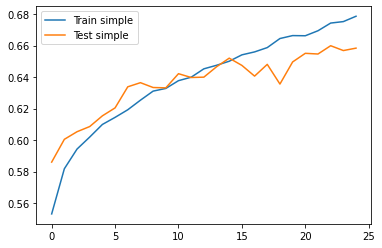

In [ ]:
# display the curves
net_simple_train = [0.5530759951749096, 0.5817523851299484, 0.5942537558942866, 0.6018752056146507, 0.6098804693497094, 0.6143765763789889, 0.6192016668494352, 0.6252878605110209, 0.6310450707314399, 0.6327448185108017, 0.6376795701283036, 0.6398727930694155, 0.645191358701612, 0.6474394122162518, 0.6500164491720584, 0.6540739116131155, 0.6559381511130606, 0.6586796797894506, 0.6644368900098695, 0.6663011295098147, 0.6661914683627591, 0.6693716416273714, 0.6742515626713456, 0.6751836824213181, 0.6785831779800416]
net_simple_test =[0.5859649122807018, 0.6004385964912281, 0.6052631578947368, 0.6085526315789473, 0.6153508771929824, 0.6203947368421052, 0.6337719298245614, 0.6364035087719299, 0.6333333333333333, 0.6331140350877194, 0.6421052631578947, 0.6396929824561404, 0.6399122807017544, 0.6464912280701754, 0.6519736842105263, 0.6473684210526316, 0.6405701754385965, 0.6480263157894737, 0.6355263157894737, 0.6495614035087719, 0.6550438596491228, 0.6546052631578947, 0.6598684210526315, 0.6567982456140351, 0.6583333333333333]

plt.plot(net_simple_train, label="Train simple")
plt.plot(net_simple_test, label="Test simple")
plt.legend()
plt.show()